Building on the tutorial at https://pyro.ai/examples/sir_hmc.html, the folks at Pyro created an additional interface for SIR modeling that compresses much of the info that that tutorial provided into a concrete interface for compartmental modeling. Below is that work, drawn from http://pyro.ai/examples/epi_intro.html

This is my second notebook in this "series". Will again use the compartmental model, but this time for SEIR modeling. Due to difficulty in finding this data in the real world (not to mention how hard it was to model in SIR to begin with), I'll stick with synthetic data for now. Using MCMC and SVI methods to estimate epidemic parameters and see if intervention helps, and to what extent. 

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

/app/python/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
pyro.__version__

'1.5.0'

In [3]:
class SimpleSEIRModel(CompartmentalModel):
    """
    Susceptible-Exposed-Infected-Recovered model.

    To customize this model we recommend forking and editing this class.

    This is a stochastic discrete-time discrete-state model with four
    compartments: "S" for susceptible, "E" for exposed, "I" for infected,
    and "R" for recovered individuals (the recovered individuals are
    implicit: ``R = population - S - E - I``) with transitions
    ``S -> E -> I -> R``.

    :param int population: Total ``population = S + E + I + R``.
    :param float incubation_time: Mean incubation time (duration in state
        ``E``). Must be greater than 1.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> E``
        transitions. This allows false negative but no false positives.
    """

    def __init__(self, population, incubation_time, recovery_time, data):
        compartments = ("S", "E", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)

        assert isinstance(incubation_time, float)
        assert incubation_time > 1
        self.incubation_time = incubation_time

        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time

        self.data = data

    def global_model(self):
        tau_e = self.incubation_time
        tau_i = self.recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(10, 10))
        return R0, tau_e, tau_i, rho

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "E": 0, "I": 1}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, rho = params

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                          infection_dist(individual_rate=R0 / tau_i,    ## TODO: it seems like in paper, (1-u) * (b1*_i1 + b2*_i2 + b3*_i3)/_n*_s
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        E2I = pyro.sample("E2I_{}".format(t),
                          binomial_dist(state["E"], 1 / tau_e))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau_i))

        # Update compartments with flows.
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2E, rho),
                    obs=self.data[t] if t_is_observed else None)



## Generating Data

What if I don't want to do this? 

In [4]:
population = 329064930
recovery_time = 10.
incubation_time = 14.
empty_data = [None] * 300
model = SimpleSEIRModel(population, incubation_time, recovery_time, empty_data)

# We'll repeatedly generate data until a desired number of infections is found.
pyro.set_rng_seed(20200709)
for attempt in range(100):
    synth_data = model.generate({"R0": 1.7})
    total_infections = synth_data["S2E"].sum().item()
   # if 4000 <= total_infections <= 6000:
    break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


Simulated 13074133.0 infections after 1 attempts


For the model to work, it requires S, S2I, I, I2R, obs (noisy S2I), R0, and rho. 


At the moment, all of these things are synthetically generated, after we first specify R0, rho and population. 

For real world, I'll try this now, but we set:

S2I = obs, and use reported values for the others. In essence we no longer use the noisy observations and assume whatever is reported is right? 

I'm not sure if the model will work if we do not specify R0 or rho, so will have to try this and find out. 

#### Swapneel's comments: I think you mean we have to specify a prior for R0 and rho and the model will update that into a posterior estimate based on the data that it observes.

In [5]:
for key, value in sorted(synth_data.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))
    

E.shape = (300,)
E2I.shape = (300,)
I.shape = (300,)
I2R.shape = (300,)
R0.shape = ()
S.shape = (300,)
S2E.shape = (300,)
obs.shape = (300,)
rho.shape = ()


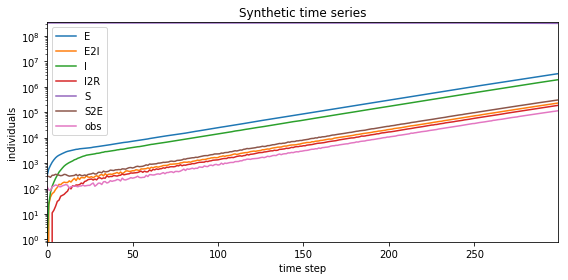

In [6]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

## Inference

In [7]:
# what if we only have obs? can we estimate using just that? 
obs = synth_data["obs"]
model = SimpleSEIRModel(population, incubation_time, recovery_time, obs) 


In [8]:
%%time
losses = model.fit_svi(num_steps=101 if smoke_test else 2001,
                       jit=True)

INFO 	 Failed to find feasible hypothesis after site obs_136. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_67. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_89. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_167. Retrying...
INFO 	 Heuristic init: R0=1.98, rho=0.356
INFO 	 Running inference...
INFO 	 step 0 loss = 1.958e+08
INFO 	 step 200 loss = 1.696e+08
INFO 	 step 400 loss = 6.419e+07
INFO 	 step 600 loss = 1.354e+05
INFO 	 step 800 loss = 1.288e+04
INFO 	 step 1000 loss = 6872
INFO 	 step 1200 loss = 3575
INFO 	 step 1400 loss = 1911
INFO 	 step 1600 loss = 1180
INFO 	 step 1800 loss = 761.7
INFO 	 step 2000 loss = 529.8
INFO 	 SVI took 47.2 seconds, 42.4 step/sec


CPU times: user 8min 39s, sys: 55.2 s, total: 9min 34s
Wall time: 1min


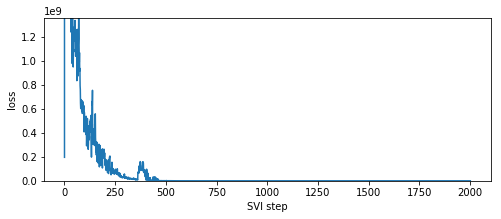

In [9]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss")
plt.ylim(min(losses), max(losses[50:]));

In [10]:
for key, value in sorted(model.samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

R0.shape = (100, 1)
auxiliary.shape = (100, 1, 3, 300)
rho.shape = (100, 1)


In [11]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 864 ms, sys: 3.82 ms, total: 868 ms
Wall time: 879 ms


/opt/conda/envs/pyprobenv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/app/python/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/app/python/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/app/python/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

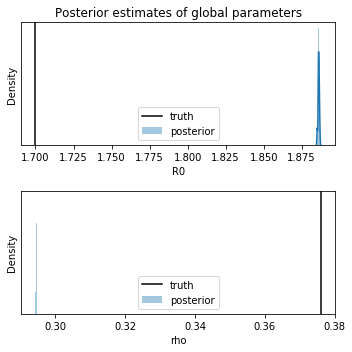

In [12]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()


## MCMC

In [13]:
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 200,
                      jit_compile=True,)

INFO 	 Running inference...
Sample: 100%|██████████| 400/400 [00:56,  7.09it/s, step size=8.67e-04, acc. prob=0.867]


## Prediction

In [14]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 818 ms, sys: 5.9 ms, total: 824 ms
Wall time: 835 ms


In [15]:
for key, value in sorted(samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

E.shape = (200, 300)
E2I.shape = (200, 300)
I.shape = (200, 300)
I2R.shape = (200, 300)
R0.shape = (200, 1)
S.shape = (200, 300)
S2E.shape = (200, 300)
auxiliary.shape = (200, 1, 3, 300)
obs.shape = (200, 300)
rho.shape = (200, 1)


/opt/conda/envs/pyprobenv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/app/python/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/app/python/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/app/python/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

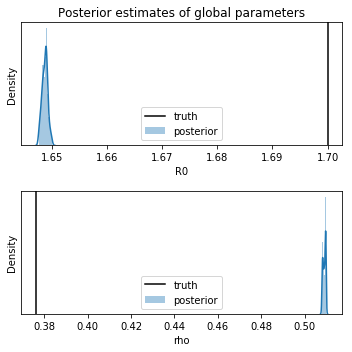

In [16]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()


## Forecasting

In [17]:
%time
samples = model.predict(forecast=30)

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


INFO 	 Forecasting 30 steps ahead...


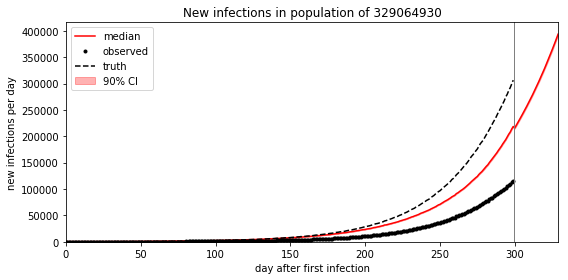

In [18]:

def plot_forecast(samples):
    duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2E = samples["S2E"]
    median = S2E.median(dim=0).values
    p05 = S2E.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2E.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2E"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()

plot_forecast(samples)

A suggestion of the authors is to use MCMC rather than SVI to estimate, and this will produce better results with only a little longer compute time. I will avoid doing that for the moment, because I would consider it a higher priority to figure out how to run this model with actual data, rather than manufactured. 

In [19]:
synth_data

OrderedDict([('R0', tensor(1.7000)),
             ('rho', tensor(0.3762)),
             ('I2R',
              tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1000e+01, 1.4000e+01, 2.0000e+01,
                      3.1000e+01, 3.5000e+01, 5.0000e+01, 5.4000e+01, 5.9000e+01, 6.9000e+01,
                      7.9000e+01, 1.0900e+02, 9.7000e+01, 1.2800e+02, 1.2300e+02, 1.3800e+02,
                      1.3700e+02, 1.4200e+02, 1.6400e+02, 1.5400e+02, 1.8900e+02, 2.0000e+02,
                      2.2400e+02, 2.3000e+02, 2.3700e+02, 2.1600e+02, 2.3600e+02, 2.1900e+02,
                      2.6100e+02, 2.6500e+02, 2.4200e+02, 2.6100e+02, 2.5500e+02, 3.1500e+02,
                      2.8600e+02, 2.9900e+02, 2.9700e+02, 3.2400e+02, 3.1600e+02, 3.0900e+02,
                      3.2700e+02, 3.3400e+02, 3.7300e+02, 3.4700e+02, 3.5900e+02, 3.7300e+02,
                      3.8000e+02, 4.1100e+02, 4.0400e+02, 4.1200e+02, 4.1700e+02, 4.2700e+02,
                      4.5500e+02, 4.8300e+02, 4.3500e+02, 